In [1]:
#!source ~/scripts/renew_cms.sh
import processor.FCNC_FR_validation as fr
import matplotlib.pyplot as plt
import awkward as ak

from coffea import processor, hist
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import Weights, PackedSelection

import numpy as np
import pandas as pd
from yahist import Hist1D, Hist2D

# this is all very bad practice
from Tools.objects import *
from Tools.basic_objects import *
from Tools.cutflow import *
from Tools.config_helpers import *
from Tools.triggers import *
from Tools.btag_scalefactors import *
from Tools.lepton_scalefactors import *
from Tools.nano_mapping import make_fileset, nano_mapping
from processor.meta_processor import get_sample_meta
from plots.helpers import makePlot, scale_and_merge

In [2]:
from klepto.archives import dir_archive
from processor.default_accumulators import desired_output, add_processes_to_output, dataset_axis, pt_axis, eta_axis

from Tools.helpers import get_samples
from Tools.config_helpers import redirector_ucsd, redirector_fnal
from Tools.nano_mapping import make_fileset
import glob

year = 2016

year_2016_files = "/hadoop/cms/store/user/ksalyer/FCNC_NanoSkim/fcnc_v3/TTJets_TuneCUETP8M2T4_13TeV-amcatnloFXFX-pythia8_RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_NANOAODSIM_fcnc_v3/*.root"
year_2017_files = "/hadoop/cms/store/user/ksalyer/FCNC_NanoSkim/fcnc_v3/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8_RunIIFall17NanoAODv7-PU2017_12Apr2018_Nano02Apr2020_new_pmx_102X_mc2017_realistic_v8-v1_NANOAODSIM_fcnc_v3/*.root"
year_2018_files = "/hadoop/cms/store/user/ksalyer/FCNC_NanoSkim/fcnc_v3/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8_RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21_ext2-v1_NANOAODSIM_fcnc_v3/*.root"
fileset = {}
for file in glob.glob(year_2016_files):
    fileset[file[file.find('output_'):file.find('.root')]] = [file]
#fileset = {"2016":glob.glob(year_2016_files)}
#fileset = make_fileset(['QCD'], samples, redirector=redirector_ucsd, small=True) 
add_processes_to_output(fileset, desired_output)
dataset_axis            = hist.Cat("dataset",       "Primary dataset")
pt_axis                 = hist.Bin("pt",            r"$p_{T}$ (GeV)", int(100/25), 0, 100) # 5 GeV is fine enough
p_axis                  = hist.Bin("p",             r"$p$ (GeV)", int(2500/5), 0, 2500) # 5 GeV is fine enough
ht_axis                 = hist.Bin("ht",            r"$H_{T}$ (GeV)", 500, 0, 5000)
mass_axis               = hist.Bin("mass",          r"M (GeV)", 1000, 0, 2000)
eta_axis                = hist.Bin("eta",           r"$\eta$", 100, -5.0, 5.0)
phi_axis                = hist.Bin("phi",           r"$\phi$", 2, 0, 3.2)
delta_axis              = hist.Bin("delta",         r"$\delta$", 100,0,10 )
multiplicity_axis       = hist.Bin("multiplicity",  r"N", 20, -0.5, 19.5)
n1_axis                 = hist.Bin("n1",  r"N", 4, -0.5, 3.5)
n2_axis                 = hist.Bin("n2",  r"N", 4, -0.5, 3.5)
n_ele_axis              = hist.Bin("n_ele",  r"N", 4, -0.5, 3.5) # we can use this as categorization for ee/emu/mumu
ext_multiplicity_axis   = hist.Bin("multiplicity",  r"N", 100, -0.5, 99.5) # e.g. for PV
norm_axis               = hist.Bin("norm",          r"N", 25, 0, 1)
score_axis              = hist.Bin("score",          r"N", 100, 0, 1)

desired_output.update({
    "EE_SR": hist.Hist("Counts", dataset_axis),
    "EE_CR": hist.Hist("Counts", dataset_axis),
    "EE_CR_weighted": hist.Hist("Counts", dataset_axis),
    "MM_SR": hist.Hist("Counts", dataset_axis),
    "MM_CR": hist.Hist("Counts", dataset_axis),
    "MM_CR_weighted": hist.Hist("Counts", dataset_axis),
    "EM_SR": hist.Hist("Counts", dataset_axis),
    "EM_CR": hist.Hist("Counts", dataset_axis),
    "EM_CR_weighted": hist.Hist("Counts", dataset_axis),
    "ME_SR": hist.Hist("Counts", dataset_axis),
    "ME_CR": hist.Hist("Counts", dataset_axis),
    "ME_CR_weighted": hist.Hist("Counts", dataset_axis),
    #############################################################
    "MET_CR" : hist.Hist("Counts", dataset_axis, pt_axis, phi_axis),
    "MET_CR_weighted" : hist.Hist("Counts", dataset_axis, pt_axis, phi_axis),
    "MET_SR" : hist.Hist("Counts", dataset_axis, pt_axis, phi_axis),
    "pt_LeadLep_CR" : hist.Hist("Counts", dataset_axis, pt_axis),
    "pt_LeadLep_CR_weighted" : hist.Hist("Counts", dataset_axis, pt_axis),
    "pt_LeadLep_SR" : hist.Hist("Counts", dataset_axis, pt_axis),
    "N_jet_CR" : hist.Hist("Counts", dataset_axis, multiplicity_axis),
    "N_jet_CR_weighted" : hist.Hist("Counts", dataset_axis, multiplicity_axis),
    "N_jet_SR" : hist.Hist("Counts", dataset_axis, multiplicity_axis)
    
})

In [ ]:
exe_args = {
    'workers': 16,
    'function_args': {'flatten': False},
    "schema": NanoAODSchema,
    "skipbadfiles": True,
}
exe = processor.futures_executor

print ("I'm running now")

output = processor.run_uproot_job(
    fileset,
    "Events",
    fr.nano_analysis(year=year, variations=[], accumulator=desired_output),
    exe,
    exe_args,
    chunksize=250000
)

I'm running now


Preprocessing:   0%|          | 0/43 [00:00<?, ?file/s]

Processing:   0%|          | 0/43 [00:00<?, ?chunk/s]

/home/users/cmcmahon/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference target for Electron_photonIdx => Photon
  warnings.warn(
/home/users/cmcmahon/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference target for Electron_photonIdx => Photon
  warnings.warn(
/home/users/cmcmahon/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference target for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(
/home/users/cmcmahon/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference target for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(
/home/users/cmcmahon/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Mis

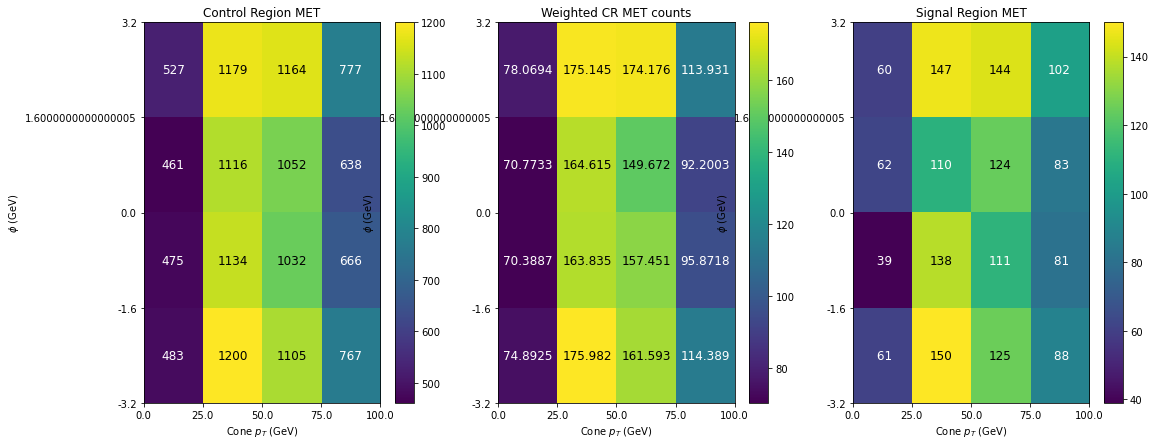

In [8]:
pt_bins = hist.Bin("pt", r'$P_{T}\ GeV$', [20., 35., 45., 65., 100.])#[[0, 25.],[25., 35.], [35., 45.], [45., 65.], [65., 120.]])
phi_bins = hist.Bin('eta', r'$eta\ (GeV)$',[-2.5, -1.0, 1.0,  2.5])
# eta_bins_e = hist.Bin('eta', r'$eta\ (GeV)$',[-2.5, -1.5, 1.5, 2.5])

def make_yahist(x):
    x_axis_0 = x.axes()[0].name
    x_axis_1 = x.axes()[1].name
    #breakpoint()
    yahist_x = Hist2D.from_bincounts(x.values()[()].T, (x.axis(x_axis_0).edges(), x.axis(x_axis_1).edges()))
    return yahist_x

def divide_2D_hist(x, y):
    x_axis_0 = x.axes()[0].name
    x_axis_1 = x.axes()[1].name
    y_axis_0 = y.axes()[0].name
    y_axis_1 = y.axes()[1].name
    yahist_x = Hist2D.from_bincounts(x.values()[()].T, (x.axis(x_axis_0).edges(), x.axis(x_axis_1).edges()))
    yahist_y = Hist2D.from_bincounts(y.values()[()].T, (y.axis(y_axis_0).edges(), y.axis(y_axis_1).edges()))
    return yahist_x.divide(yahist_y)

fig, ax = plt.subplots(1, 3, figsize=(18, 7))
make_yahist(output["MET_CR"].sum("dataset")).plot(show_counts=True, equidistant='xy', ax=ax[0])
ax[0].set_xlabel(r'Cone $p_T$ (GeV)')
ax[0].set_ylabel(r'$\phi$ (GeV)')
ax[0].set_title('Control Region MET')

make_yahist(output["MET_CR_weighted"].sum("dataset")).plot(show_counts=True, equidistant='xy', ax=ax[1])
ax[1].set_xlabel(r'Cone $p_T$ (GeV)')
ax[1].set_ylabel(r'$\phi$ (GeV)')
ax[1].set_title('Weighted CR MET counts')

make_yahist(output["MET_SR"].sum("dataset")).plot(show_counts=True, equidistant='xy', ax=ax[2])
ax[2].set_xlabel(r'Cone $p_T$ (GeV)')
ax[2].set_ylabel(r'$\phi$ (GeV)')
ax[2].set_title('Signal Region MET')


plt.draw()

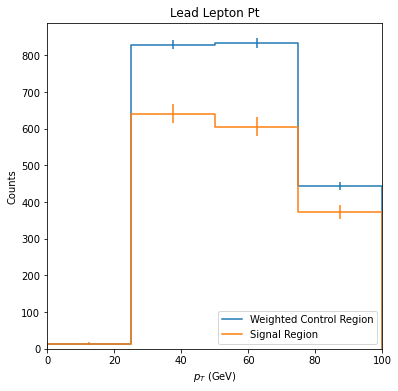

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
hist.plot1d(output["pt_LeadLep_CR_weighted"].sum("dataset"))
hist.plot1d(output["pt_LeadLep_SR"].sum("dataset"))
ax.set_label("Signal Region")
ax.legend(["Weighted Control Region", "Signal Region"])
plt.title("Lead Lepton Pt")
plt.draw()

In [ ]:
regions = ["EE_CR", "EE_CR_weighted", "EE_SR", "MM_CR", "MM_CR_weighted", "MM_SR", "EM_CR", "EM_CR_weighted", "EM_SR", "ME_CR", "ME_CR_weighted", "ME_SR"]
counts = [float(output[r].sum("dataset").values()[()]) for r in regions]

for n in range(len(regions)):
    print("region: {0} \t count {1:.4f}".format(regions[n], counts[n]))
    
print("\n")
    
for n in range(len(regions)):
    print("{1:.4f}".format(regions[n], counts[n]))

In [11]:
import yahist

bins_pt = np.array([10., 15., 20., 25., 35., 50, 70])
bins_eta = np.array([0, 0.8, 1.479, 2.5])

muon_counts_2018 = np.array([
    [0., 0., 0.],
    [0.485363, 0.548621, 0.662505],
    [0.169757, 0.227283, 0.273878],
    [0.0570671, 0.0852324, 0.0950307],
    [0.0449928, 0.0530749, 0.0711829],
    [0.0398129, 0.0531309, 0.046544]
])

muon_counts_2017 = np.array([
    [0., 0., 0.,],
    [0.487579, 0.546476, 0.623434],
    [0.180429, 0.23425, 0.277212],
    [0.0561123, 0.082896, 0.0876005],
    [0.045945, 0.0490797, 0.062571],
    [0.0407374, 0.0527785, 0.0482802]
])

muon_counts_2016 = np.array([
    [0.3940, 0.4297, 0.4809],
    [0.1301, 0.1486, 0.1959],
    [0.0885, 0.0979, 0.1375],
    [0.0805, 0.0878, 0.1090],
    [0.0785, 0.0788, 0.1008],
    [0.0793, 0.0707, 0.1073]
])

electron_counts_2018 = np.array([
    [0., 0., 0.],
    [0.469227, 0.522789, 0.407835],
    [0.143496, 0.201734, 0.146049],
    [0.0811412, 0.081194, 0.150573],
    [0.0798284, 0.125701, 0.157778],
    [0.0940064, 0.172235, 0.169947]
])

electron_counts_2017 = np.array([
    [0., 0., 0.],
    [0.473089, 0.567948, 0.392926],
    [0.158189, 0.221255, 0.158681],
    [0.0711147, 0.0829365, 0.142449],
    [0.0724598, 0.12906, 0.147341],
    [0.0876978, 0.158748, 0.181927]
])

electron_counts_2016 = np.array([
    [0., 0., 0.],
    [0.3789, 0.3942, 0.4086],
    [0.1643, 0.1805, 0.1628],
    [0.1226, 0.1298, 0.1335],
    [0.1568, 0.1756, 0.1381],
    [0.2846, 0.1756, 0.2120]
])


electron_2018 = Hist2D.from_bincounts(electron_counts_2018.T, (bins_pt, bins_eta))
electron_2017 = Hist2D.from_bincounts(electron_counts_2017.T, (bins_pt, bins_eta))
electron_2016 = Hist2D.from_bincounts(electron_counts_2016.T, (bins_pt, bins_eta))
muon_2018 = Hist2D.from_bincounts(muon_counts_2018.T, (bins_pt, bins_eta))
muon_2017 = Hist2D.from_bincounts(muon_counts_2017.T, (bins_pt, bins_eta))
muon_2016 = Hist2D.from_bincounts(muon_counts_2016.T, (bins_pt, bins_eta))


Text(0.5, 1.0, 'Legacy Muon Fake Rate (2016)')

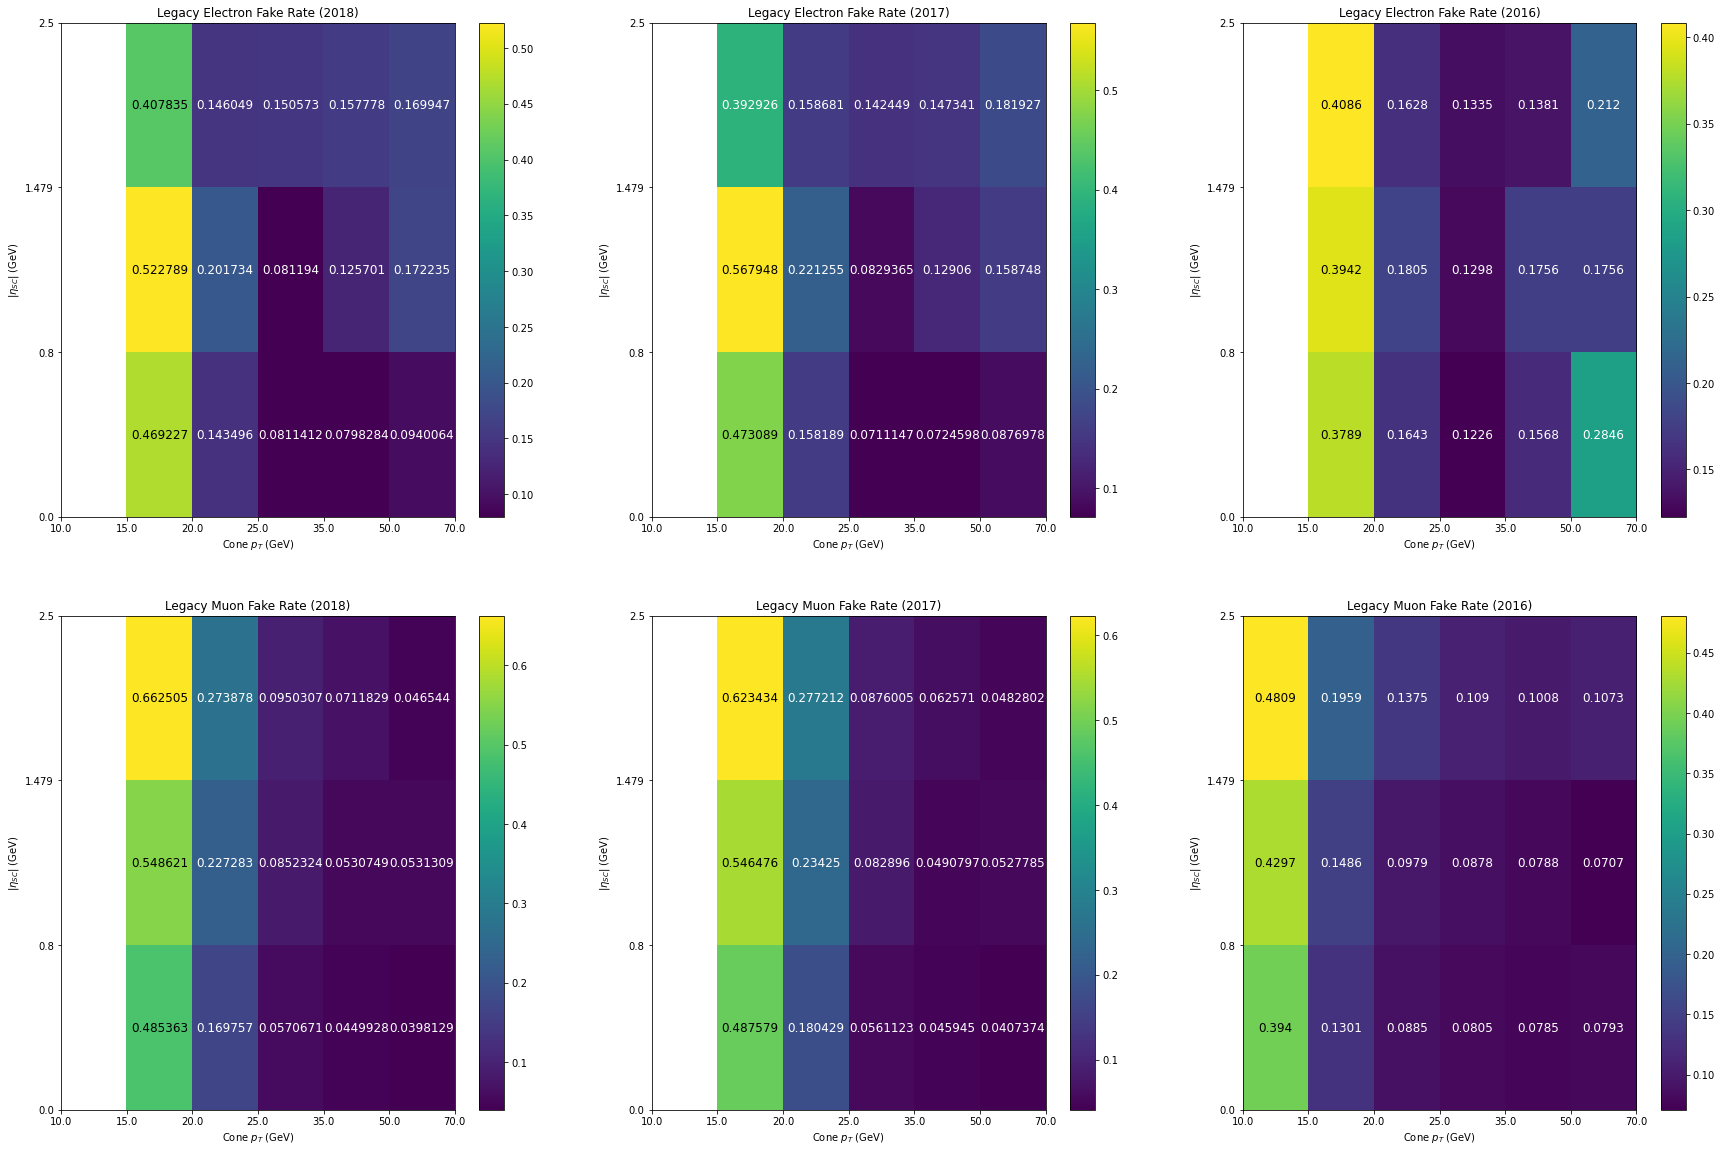

In [15]:
fig, ax = plt.subplots(2, 3, figsize = (30,20))

electron_2018.plot(show_counts=True, equidistant='xy', ax=ax[0, 0])
ax[0, 0].set_xlabel(r'Cone $p_T$ (GeV)')
ax[0, 0].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[0, 0].set_title('Legacy Electron Fake Rate (2018)')


muon_2018.plot(show_counts=True, equidistant='xy', ax=ax[1, 0])
ax[1, 0].set_xlabel(r'Cone $p_T$ (GeV)')
ax[1, 0].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[1, 0].set_title('Legacy Muon Fake Rate (2018)')

electron_2017.plot(show_counts=True, equidistant='xy', ax=ax[0, 1])
ax[0, 1].set_xlabel(r'Cone $p_T$ (GeV)')
ax[0, 1].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[0, 1].set_title('Legacy Electron Fake Rate (2017)')


muon_2017.plot(show_counts=True, equidistant='xy', ax=ax[1, 1])
ax[1, 1].set_xlabel(r'Cone $p_T$ (GeV)')
ax[1, 1].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[1, 1].set_title('Legacy Muon Fake Rate (2017)')

electron_2016.plot(show_counts=True, equidistant='xy', ax=ax[0, 2])
ax[0, 2].set_xlabel(r'Cone $p_T$ (GeV)')
ax[0, 2].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[0, 2].set_title('Legacy Electron Fake Rate (2016)')


muon_2016.plot(show_counts=True, equidistant='xy', ax=ax[1, 2])
ax[1, 2].set_xlabel(r'Cone $p_T$ (GeV)')
ax[1, 2].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[1, 2].set_title('Legacy Muon Fake Rate (2016)')



In [7]:
np.sum(np.zeros(1))

0.0

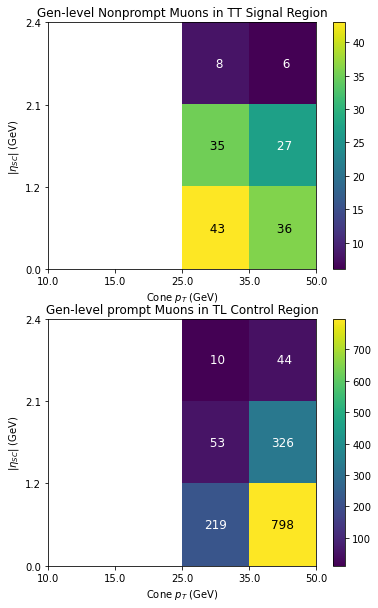

In [5]:
#plot tight and loose counts for muons
fig, ax = plt.subplots(2, 1, figsize = (6,10))

make_yahist(EE_SR.sum("dataset")).plot(show_counts=True, equidistant='xy', ax=ax[0])
ax[0].set_xlabel(r'Cone $p_T$ (GeV)')
ax[0].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[0].set_title('Gen-level Nonprompt Muons in TT Signal Region')

make_yahist(EE_CR.sum("dataset")).plot(show_counts=True, equidistant='xy', ax=ax[1])
ax[1].set_xlabel(r'Cone $p_T$ (GeV)')
ax[1].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[1].set_title('Gen-level prompt Muons in TL Control Region')

plt.show()

In [16]:
# import pickle
# pickle.dump(electron_2018, open("../data/fake_rate/FR_electron_2018.p", "wb"))
# pickle.dump(electron_2017, open("../data/fake_rate/FR_electron_2017.p", "wb"))
# pickle.dump(electron_2016, open("../data/fake_rate/FR_electron_2016.p", "wb"))
# pickle.dump(muon_2018, open("../data/fake_rate/FR_muon_2018.p", "wb"))
# pickle.dump(muon_2017, open("../data/fake_rate/FR_muon_2017.p", "wb"))
# pickle.dump(muon_2016, open("../data/fake_rate/FR_muon_2016.p", "wb"))